# Learning about the Efficient Frontier - Tests on the optimal portfolio in the Markowitz approach

I really liked the Blog post on the efficient frontier [by Thomas Wiecki et al.](http://blog.quantopian.com/markowitz-portfolio-optimization-2/) and a lot of the stuff here is strongly inspired by that post.

I wanted to understand several things and I think that the script helps a bit. Stuff that I found interesting:

- A random portfolio of more than 5 shares is rarely close to the efficient frontier
- The mean has tremendous error bars, just due to the finite length of the sample.
- The Algorithm gets the variance down, but it is really bad in optimizing the return.
- Beating the random portfolio is hard.

Let me import the necessary stuff first.

In [1]:
%matplotlib inline
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from pylab import *
import pandas as pd

from scipy.stats import norm
from scipy.optimize import curve_fit

# stuff for the optimization
import cvxopt as opt
from cvxopt import blas, solvers 

In [2]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k) 

def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''
    
    mi = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * mi.T
    sigma = np.sqrt(w * C * w.T)
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

This function will allow us to calculate the optimal portfolio at some point. Right now it takes the whole series, but I would like to do it directly on the variance $\sigma_i$, the correlation matrix $\mathbf{C}$ and the expected returns $m_i$

In [3]:
def get_return_and_cov_with_err(returns):
    '''
    Get the mean return and the standard deviation of each series by assuming a standard distribution.
    This allows me also to get the errors on those estimates. There is no fitting involved and I simply
    use known relations.
    '''
    n = len(returns)
    returns = np.asmatrix(returns)
    
    S = np.cov(returns)
    pbar = np.mean(returns, axis=1)
    
    return S, pbar

def optimal_portfolio(S, pbar, n, rf):
    '''
    Gives back the optimal portfolio given the standard deviation etc. As optimal we see here the tangential portfolio.
    '''
    
    # Convert to cvxopt matrices
    S = opt.matrix(S)
    pbar = opt.matrix(pbar)
    
    N = 50
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]

    # Create constraint matrices
    
    # we have the constraint G dot x <= h. So these constraints imply that the weights are between 0 and 1
    G = -opt.matrix(np.eye(n))
    h = opt.matrix(0.0, (n ,1))
    
    # we have the constraint A dot x = b. So this implies that the sum of the weights has to be 1
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = np.asarray([blas.dot(pbar, x) for x in portfolios])
    risks = np.asarray([np.sqrt(blas.dot(x, S*x)) for x in portfolios])
    # CALCULATE THE OPTIMAL PORTFOLIO
    slope = (returns-rf)/risks
    opt_s_ind = slope.argmax()
    return np.asarray(portfolios[opt_s_ind]), np.asarray(returns), np.asarray(risks), portfolios

def optimal_portfolio_in_blog(returns):
    '''
    Gives back the optimal portfolio given the standard deviation etc. As optimal we see here
    the portfolio with the highest return. This comes directly from a Blog post on Quantopian.
    '''
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

# Run the code now

some important parameters

In [4]:
n_assets = 30
n_obs = 800
n_portfolios = int(1E4)# number of random portfolios that we create
rf_year = 0.01#risk free return
doy = 200 #days per year
n_bins = 200# bins for the distribution fitting

##Do some random walk testing with a normal distribution

Create a number of normally distributed returns and look at their typical datas.

In [5]:
return_vec = np.random.randn(n_assets, n_obs)#using the normal distribution
# get some numbers on the portfolio
s_means = return_vec.mean(axis=1)
s_stds = return_vec.std(axis=1)

Now, that we know the important things about each stock, we can turn to the creation of a portfolio. To optimize the portofolio we take two approaches:
- One is just a random portfolio This teaches us later on that random portfolios are not that good to find the efficient frontier for larger numbers of portfolios.
- The second one is an optimization of the volatility at a given risk. For that we use cvxopt.

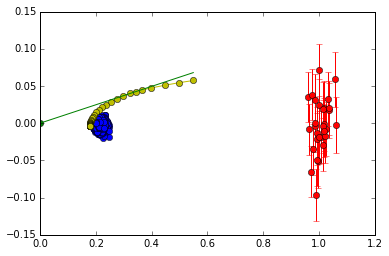

In [6]:
means, stds = np.column_stack([
    random_portfolio(return_vec) 
    for _ in xrange(n_portfolios)
])

rf_d = rf_year/doy
solvers.options['show_progress'] = False

S, pbar = get_return_and_cov_with_err(return_vec)
weights, returns, risks, ports = optimal_portfolio(S, pbar, n_assets, rf_d)
# get intersection between the portfolio and the risk free one
opt_slope = max((returns-rf_d)/risks)
plot_risks = linspace(0,max(risks),5)

# and plot it up
#plt.figure(2)
plt.clf()
plt.plot(stds,means, 'bo')
plt.errorbar(s_stds,s_means, yerr = s_stds/sqrt(n_obs), fmt = 'ro')
plt.plot(risks, returns, 'y-o')
plt.plot(0, rf_d, 'go')
plot(plot_risks, opt_slope*plot_risks+rf_d, 'g-')

## Now run the real datas in Zipline

## First do some tests on the datas

Prepare to read the data

In [7]:
from zipline.utils.factory import load_bars_from_yahoo

symbols = ['IBM', 'GLD', 'XOM', 'AAPL', 'MSFT', 'TLT', 'SHY']
dow_symbols = ['MMM', 'AXP', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'DIS', 'DD',
              'XOM', 'GE', 'GS', 'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MRK', 
               'MSFT', 'NKE', 'PFE', 'PG', 'TRV', 'UTX', 'UNH', 'VZ', 'V','WMT']
end = pd.Timestamp.utcnow()
start = end - n_obs * pd.tseries.offsets.BDay()

dow_jones = load_bars_from_yahoo(stocks=['DJIA'],
                            start=start, end=end)
data = load_bars_from_yahoo(stocks=dow_symbols,
                            start=start, end=end)

close = data.loc[:, :, 'price']
dow_close = dow_jones.loc[:, :, 'price']
close = (close.fillna(method='ffill')).fillna(method='backfill')
n_close = close/close.ix[0,:]
n_dow_close = dow_close/dow_close.ix[0]

DJIA
MMM
AXP
AAPL
BA
CAT
CVX
CSCO
KO
DIS
DD
XOM
GE
GS
HD
IBM
INTC
JNJ
JPM
MCD
MRK
MSFT
NKE
PFE
PG
TRV
UTX
UNH
VZ
V
WMT


In [8]:
c_rets = close.pct_change()
c_rets = c_rets.as_matrix()
c_rets = c_rets[1:,:]
c_rets = c_rets.T

dow_rets = dow_close.pct_change()
dow_rets = dow_rets.as_matrix()
dow_rets = dow_rets[1:,:]
dow_rets = dow_rets.T

c_means = c_rets.mean(axis=1)
c_stds = c_rets.std(axis=1)

dow_mean = dow_rets.mean(axis=1)
dow_std = dow_rets.std(axis=1)

s= shape(c_rets)
n_obs = s[1]

Get the optimal portfolio and a lot random portfolios here. 

In [9]:
# the random portfolio
cr_means, cr_stds = np.column_stack([
    random_portfolio(c_rets) 
    for _ in xrange(n_portfolios)
])

# the efficient frontier one
S_real, pbar_real = get_return_and_cov_with_err(c_rets)
c_weights, c_returns, c_risks, c_ports = optimal_portfolio(S_real, pbar_real, n_assets, rf_d)
#c_weights, c_returns, c_risks, c_ports = optimal_portfolio(c_rets,rf_d)
c_returns = np.asarray(c_returns)
c_risks = np.asarray(c_risks)
slope = (c_returns-rf_d)/c_risks
opt_slope = max(slope)
opt_s_ind = slope.argmax()
opt_return = c_returns[opt_s_ind]
print opt_return
plot_risks = linspace(0,max(c_risks),5)

0.00114538405977


## Now look at the trading

I do not understand this part for the moment, but I am not sure that it is that important.

In [10]:
import zipline
from zipline.api import (add_history, 
                         history, 
                         set_slippage, 
                         slippage,
                         set_commission, 
                         commission, 
                         order_target_percent)

from zipline import TradingAlgorithm


def initialize(context):
    '''
    Called once at the very beginning of a backtest (and live trading). 
    Use this method to set up any bookkeeping variables.
    
    The context object is passed to all the other methods in your algorithm.

    Parameters

    context: An initialized and empty Python dictionary that has been 
             augmented so that properties can be accessed using dot 
             notation as well as the traditional bracket notation.
    
    Returns None
    '''
    # Register history container to keep a window of the last 100 prices.
    add_history(100, '1d', 'price')
    
    # Turn off the slippage model
    set_slippage(slippage.FixedSlippage(spread=0.0))
    # Set the commission model (Interactive Brokers Commission)
    set_commission(commission.PerShare(cost=0.01, min_trade_cost=1.0))
    context.tick = 0
    
def handle_data(context, data):
    '''
    Called when a market event occurs for any of the algorithm's 
    securities. 

    Parameters

    data: A dictionary keyed by security id containing the current 
          state of the securities in the algo's universe.

    context: The same context object from the initialize function.
             Stores the up to date portfolio as well as any state 
             variables defined.

    Returns None
    '''
    # Allow history to accumulate 100 days of prices before trading
    # and rebalance every day thereafter.
    context.tick += 1
    if context.tick < 100:
        return
    # Get rolling window of past prices and compute returns
    prices = history(100, '1d', 'price').dropna()
    returns = prices.pct_change().dropna()
    _, n_secs = returns.shape
    try:
        # Perform Markowitz-style portfolio optimization
        S, pbar = get_return_and_cov_with_err(returns.T)
        weights,_,_,_ = optimal_portfolio(S, pbar, n_secs, 0)
        #weights, _, _ = optimal_portfolio_in_blog(returns.T)
        # Rebalance portfolio accordingly
        for stock, weight in zip(prices.columns, weights):
            order_target_percent(stock, weight)
    except ValueError as e:
        # Sometimes this error is thrown
        # ValueError: Rank(A) < p or Rank([P; A; G]) < n
        pass
        
# Instantinate algorithm        
algo = TradingAlgorithm(initialize=initialize, 
                        handle_data=handle_data)
# Run algorithm
results = algo.run(data)

[2015-04-12 15:33:22.357941] INFO: Performance: Simulated 770 trading days out of 770.
[2015-04-12 15:33:22.358737] INFO: Performance: first open: 2012-03-19 13:31:00+00:00
[2015-04-12 15:33:22.359473] INFO: Performance: last close: 2015-04-10 20:00:00+00:00


Plot it up. Some comments about the plots:

- In the first figure we compare the Dow Jones benchmark (in green) with the portfolio (in blue)
- In the second plot we plot the return as a function of the variance. The red dots are the indiviual stocks with statistical errorbars. The yellow parabole is the efficient frontier. The yellow dot is our 'tangential' portfolio. The green dot is the benchmark. The blue dots are random portfolios each containing some portion of each of the 30 stocks. The straight green line is the tangente.

770


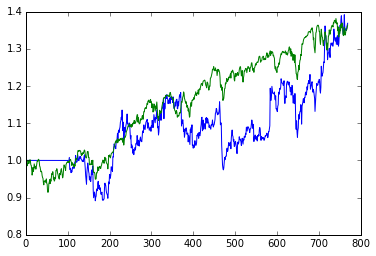

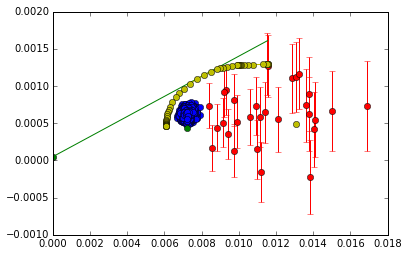

In [12]:
# get some numbers of the portfolio
n_port = results.portfolio_value/results.portfolio_value[0]
p_rets = results.portfolio_value.pct_change()
p_std = p_rets.std()
p_mean = p_rets.mean()

# and plot it
plt.figure(1)
plt.clf()
n_obs = len(n_port)
print n_obs
plot(arange(n_obs),n_port.values)
plot(arange(n_obs),n_dow_close.values)

plt.figure(2)
plt.clf()
plt.plot(cr_stds, cr_means, 'bo')
plt.errorbar(c_stds, c_means, yerr = c_stds/sqrt(n_obs), fmt= 'ro')
plt.plot(dow_std, dow_mean, 'go')
plt.plot(0, rf_d, 'go')
plot(plot_risks, opt_slope*plot_risks+rf_d, 'g-')
plot(c_risks,c_returns, 'y-o')
plot(p_std,p_mean, 'yo')